In [1]:
import random
import time
import numpy as np
import math 
import cv2
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO 
from typing import Callable
import os
import carla

2024-05-11 04:33:08.989547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 04:33:09.053023: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 04:33:09.356003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gp-coopperc/anaconda3/envs/Tensor/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cud

In [2]:
SECONDS_PER_EPISODE = 25
N_CHANNELS = 3
HEIGHT = 250
WIDTH = 250
FIXED_DELTA_SECONDS = 0.2
SHOW_PREVIEW = True

In [3]:
class CarEnv(gym.Env):
    SHOW_CAM = SHOW_PREVIEW
    STEER_AMT = 1.0
    im_width = WIDTH
    im_height = HEIGHT
    front_camera = None
    CAMERA_POS_Z = 1.3 
    CAMERA_POS_X = 1.4
    PREFERRED_SPEED = 60
    SPEED_THRESHOLD = 2
    
    def __init__(self):
        super(CarEnv, self).__init__()
        
        #continuous action space
        self.action_space = spaces.Box(low=np.array([-0.8]), high=np.array([0.8]), shape=(1,), dtype=np.float32)

        self.observation_space = spaces.Box(low=0.0, high=255.0,
                                            shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(4.0)
        self.client.load_world('Town01')
        self.world = self.client.get_world()

        self.settings = self.world.get_settings()
        self.settings.no_rendering_mode = True
        self.settings.fixed_delta_seconds = FIXED_DELTA_SECONDS
        self.world.apply_settings(self.settings)
        self.blueprint_library = self.world.get_blueprint_library()
        self.model_3 = self.blueprint_library.filter("model3")[0]


        
    def reset(self, seed=None, options=None):
        self.collision_hist = []
        self.actor_list = []
        self.spawn_points = self.world.get_map().get_spawn_points()
        #print(type(self.spawn_points[2]))
        #print(type(random.choice(self.spawn_points)))
        
        print("Trying to spawn vehicle...")
        self.vehicle = self.world.try_spawn_actor(self.model_3, random.choice(self.spawn_points))
        if self.vehicle is None:
            print("Failed to spawn vehicle! Resetting environment...")
            self.cleanup()  # Clean up any existing actors
            return self.reset()  # Retry resetting the environment
        
        print("Vehicle spawned successfully!")
        
        self.actor_list.append(self.vehicle)
        self.initial_location = self.vehicle.get_location()
        self.sem_cam = self.blueprint_library.find('sensor.camera.semantic_segmentation')
        self.sem_cam.set_attribute("image_size_x", f"{self.im_width}")
        self.sem_cam.set_attribute("image_size_y", f"{self.im_height}")
        self.sem_cam.set_attribute("fov", f"90")


        camera_init_trans = carla.Transform(carla.Location(z=self.CAMERA_POS_Z,x=self.CAMERA_POS_X))
        self.sensor = self.world.spawn_actor(self.sem_cam, camera_init_trans, attach_to=self.vehicle)
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        time.sleep(2) #not detect a collision when the car spawns/falls from sky.
        # showing camera at the spawn point
        if self.SHOW_CAM:
            cv2.namedWindow('Sem Camera',cv2.WINDOW_AUTOSIZE)
            cv2.imshow('Sem Camera', self.front_camera)
            cv2.waitKey(1)
        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, camera_init_trans, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.front_camera is None:
            time.sleep(0.01)#Just in case car takes any longer, because we need to be certain the car is done falling from the sky on spawn.

        self.episode_start = time.time()
        #self.steering_lock = False
        #self.steering_lock_start = None # this is to count time in steering lock and start penalising for long time in steering lock
        self.step_counter = 0
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        
        observation = self.front_camera

        return observation.astype(np.uint8), {}
    
    def step(self, action):
        self.step_counter +=1
        steer = float(action[0])  # Convert action[0] to a float
        
        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        #estimated_throttle = self.maintain_speed(kmh)

        # Apply control without changing throttle
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, steer=steer, brake=0.0))



        #distance_travelled = self.initial_location.distance(self.vehicle.get_location())

        # storing camera to return at the end in case the clean-up function destroys it
        cam = self.front_camera
        # showing image
        if self.SHOW_CAM:
            cv2.imshow('Sem Camera', cam)
            cv2.waitKey(1)

        # start defining reward from each step
        reward = 0
        done = False
        #punish for collision
        if len(self.collision_hist) != 0:
            done = True
            reward = reward - 300
            self.cleanup()

        #reward for acceleration
        if kmh < 15:
            reward = reward - 3
        elif kmh <25:
            reward = reward - 2
        elif kmh <50:
            reward = reward - 1
        elif kmh>120:
            reward = reward - 10 #punish for going too fast
        else:
            reward = reward + 1

            
         # Reward for smooth driving
        reward -= abs(steer) * 2  # Penalize harsh steering

        # Reward for progress
        reward += 2  # Small reward for every step without collision

        # check for episode duration
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            self.cleanup()
        
        observation = cam
        
        return observation.astype(np.uint8), reward, done, False, {}
        
    def cleanup(self):
        for actor in self.actor_list:
            if actor.is_alive:
                actor.destroy()
        #self.actor_list = []
        cv2.destroyAllWindows()

        
    def process_img(self, image):
        image.convert(carla.ColorConverter.CityScapesPalette)
        i = np.array(image.raw_data)
        i = i.reshape((self.im_height, self.im_width, 4))[:, :, :3] # this is to ignore the 4th Alpha channel - up to 3
        self.front_camera = i/255.0

    def collision_data(self, event):
        self.collision_hist.append(event)  

In [4]:
env = CarEnv()

model_name = "stable_baslines_randompoints2"
models_dir = f"models/{model_name}/"

logdir = f"logs/{int(time.time())}/"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

model = PPO('CnnPolicy', env, verbose=1, learning_rate=0.001, tensorboard_log=logdir)

TIMESTEPS = 500_000
iters = 0

rewards = []
episode_num = 0

while iters < 4:
    iters += 1
    print('Iteration', iters, 'is to start...')
    try:
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f"PPO")
        print('Iteration', iters, 'has been trained')
        model.save(f"{models_dir}/{TIMESTEPS*iters}")
        # Store rewards for plotting
        episode_rewards = model.ep_info_buffer
        for ep_reward in episode_rewards:
            rewards.append((episode_num, ep_reward['r']))
            episode_num += 1
            
    except ValueError as e:
        print(f"Error during training iteration {iters}: {e}")
        continue

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Iteration 1 is to start...
Trying to spawn vehicle...
Vehicle spawned successfully!
Logging to logs/1715391192/PPO_0
-----------------------------
| time/              |      |
|    fps             | 171  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 2048 |
-----------------------------


/home/gp-coopperc/anaconda3/envs/Tensor/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.03e+03   |
|    ep_rew_mean          | -8.39e+03  |
| time/                   |            |
|    fps                  | 138        |
|    iterations           | 2          |
|    time_elapsed         | 29         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03327422 |
|    clip_fraction        | 0.0882     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 614        |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0153    |
|    std                  | 0.842      |
|    value_loss           | 1.24e+03   |
----------------------------------------
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.69e+03    |
|    ep_rew_mean          | -6.47e+03   |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 11          |
|    time_elapsed         | 170         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.038781784 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.317       |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 234         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0195     |
|    std                  | 0.165       |
|    value_loss           | 459         |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3.89e+03  |
|    ep_rew_mean          | -5.62e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 20        |
|    time_elapsed         | 309       |
|    total_timesteps      | 40960     |
| train/                  |           |
|    approx_kl            | 0.0191465 |
|    clip_fraction        | 0.0733    |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.77      |
|    explained_variance   | -2.38e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 137       |
|    n_updates            | 190       |
|    policy_gradient_loss | -0.00762  |
|    std                  | 0.0393    |
|    value_loss           | 281       |
---------------------------------------
----------------------------------------
| rollout/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.95e+03    |
|    ep_rew_mean          | -5.24e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 29          |
|    time_elapsed         | 446         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.028230615 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.77        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 119         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00522    |
|    std                  | 0.0144      |
|    value_loss           | 243         |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.99e+03    |
|    ep_rew_mean          | -4.96e+03   |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 38          |
|    time_elapsed         | 587         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.010743512 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.61        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.001       |
|    loss                 | 108         |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00141    |
|    std                  | 0.00646     |
|    value_loss           | 223         |
-----------------------------------------
-------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.01e+03    |
|    ep_rew_mean          | -4.82e+03   |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 47          |
|    time_elapsed         | 724         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.027175449 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.14        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 102         |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00235     |
|    std                  | 0.00375     |
|    value_loss           | 208         |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.02e+03    |
|    ep_rew_mean          | -4.69e+03   |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 56          |
|    time_elapsed         | 863         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.022676608 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.88        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 93.7        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00676     |
|    std                  | 0.00178     |
|    value_loss           | 196         |
-----------------------------------------
-------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.03e+03   |
|    ep_rew_mean          | -4.62e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 65         |
|    time_elapsed         | 1001       |
|    total_timesteps      | 133120     |
| train/                  |            |
|    approx_kl            | 0.07919385 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | 5.5        |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 92.9       |
|    n_updates            | 640        |
|    policy_gradient_loss | 0.0142     |
|    std                  | 0.000958   |
|    value_loss           | 186        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.04e+03   |
|    ep_rew_mean          | -4.55e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 74         |
|    time_elapsed         | 1142       |
|    total_timesteps      | 151552     |
| train/                  |            |
|    approx_kl            | 0.13607305 |
|    clip_fraction        | 0.47       |
|    clip_range           | 0.2        |
|    entropy_loss         | 5.98       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 86         |
|    n_updates            | 730        |
|    policy_gradient_loss | 0.0302     |
|    std                  | 0.000599   |
|    value_loss           | 178        |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.05e+03   |
|    ep_rew_mean          | -4.51e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 83         |
|    time_elapsed         | 1278       |
|    total_timesteps      | 169984     |
| train/                  |            |
|    approx_kl            | 0.08568343 |
|    clip_fraction        | 0.504      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.24       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 84.4       |
|    n_updates            | 820        |
|    policy_gradient_loss | 0.0359     |
|    std                  | 0.000464   |
|    value_loss           | 170        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.05e+03  |
|    ep_rew_mean          | -4.46e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 92        |
|    time_elapsed         | 1418      |
|    total_timesteps      | 188416    |
| train/                  |           |
|    approx_kl            | 96.85493  |
|    clip_fraction        | 0.762     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.39      |
|    explained_variance   | -2.38e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 78.4      |
|    n_updates            | 910       |
|    policy_gradient_loss | 0.0958    |
|    std                  | 0.000406  |
|    value_loss           | 163       |
---------------------------------------
----------------------------------------
| rollout/            

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.06e+03  |
|    ep_rew_mean          | -4.44e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 101       |
|    time_elapsed         | 1555      |
|    total_timesteps      | 206848    |
| train/                  |           |
|    approx_kl            | 53.217854 |
|    clip_fraction        | 0.64      |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.5       |
|    explained_variance   | 1.19e-07  |
|    learning_rate        | 0.001     |
|    loss                 | 79.9      |
|    n_updates            | 1000      |
|    policy_gradient_loss | 0.0569    |
|    std                  | 0.000366  |
|    value_loss           | 164       |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.06e+03  |
|    ep_rew_mean          | -4.41e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 110       |
|    time_elapsed         | 1694      |
|    total_timesteps      | 225280    |
| train/                  |           |
|    approx_kl            | 115.11353 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.5       |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 70.1      |
|    n_updates            | 1090      |
|    policy_gradient_loss | 0.0999    |
|    std                  | 0.000368  |
|    value_loss           | 147       |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.06e+03   |
|    ep_rew_mean          | -4.4e+03   |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 119        |
|    time_elapsed         | 1832       |
|    total_timesteps      | 243712     |
| train/                  |            |
|    approx_kl            | 0.53285193 |
|    clip_fraction        | 0.582      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.49       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 75.6       |
|    n_updates            | 1180       |
|    policy_gradient_loss | 0.0579     |
|    std                  | 0.000364   |
|    value_loss           | 151        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.06e+03  |
|    ep_rew_mean          | -4.38e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 128       |
|    time_elapsed         | 1971      |
|    total_timesteps      | 262144    |
| train/                  |           |
|    approx_kl            | 95.29062  |
|    clip_fraction        | 0.889     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.53      |
|    explained_variance   | 1.19e-07  |
|    learning_rate        | 0.001     |
|    loss                 | 69.9      |
|    n_updates            | 1270      |
|    policy_gradient_loss | 0.122     |
|    std                  | 0.000357  |
|    value_loss           | 142       |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.06e+03  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.07e+03   |
|    ep_rew_mean          | -4.37e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 137        |
|    time_elapsed         | 2109       |
|    total_timesteps      | 280576     |
| train/                  |            |
|    approx_kl            | 0.16608992 |
|    clip_fraction        | 0.502      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.57       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 63.7       |
|    n_updates            | 1360       |
|    policy_gradient_loss | 0.0328     |
|    std                  | 0.000334   |
|    value_loss           | 130        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.07e+03  |
|    ep_rew_mean          | -4.35e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 146       |
|    time_elapsed         | 2250      |
|    total_timesteps      | 299008    |
| train/                  |           |
|    approx_kl            | 54.73179  |
|    clip_fraction        | 0.902     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.68      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 57.5      |
|    n_updates            | 1450      |
|    policy_gradient_loss | 0.114     |
|    std                  | 0.000305  |
|    value_loss           | 119       |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.07e+03   |
|    ep_rew_mean          | -4.34e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 155        |
|    time_elapsed         | 2388       |
|    total_timesteps      | 317440     |
| train/                  |            |
|    approx_kl            | 0.31734958 |
|    clip_fraction        | 0.603      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.72       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 59.6       |
|    n_updates            | 1540       |
|    policy_gradient_loss | 0.0566     |
|    std                  | 0.000286   |
|    value_loss           | 119        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.07e+03  |
|    ep_rew_mean          | -4.33e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 164       |
|    time_elapsed         | 2528      |
|    total_timesteps      | 335872    |
| train/                  |           |
|    approx_kl            | 220.20221 |
|    clip_fraction        | 0.943     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.79      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 51.6      |
|    n_updates            | 1630      |
|    policy_gradient_loss | 0.123     |
|    std                  | 0.000272  |
|    value_loss           | 107       |
---------------------------------------
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.07e+03  |
|    ep_rew_mean          | -4.32e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 173       |
|    time_elapsed         | 2665      |
|    total_timesteps      | 354304    |
| train/                  |           |
|    approx_kl            | 214.34357 |
|    clip_fraction        | 0.792     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.69      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 49        |
|    n_updates            | 1720      |
|    policy_gradient_loss | 0.0906    |
|    std                  | 0.000303  |
|    value_loss           | 101       |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.07e+03   |
|    ep_rew_mean          | -4.31e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 182        |
|    time_elapsed         | 2805       |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.53042364 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.57       |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.001      |
|    loss                 | 51.4       |
|    n_updates            | 1810       |
|    policy_gradient_loss | 0.0512     |
|    std                  | 0.000336   |
|    value_loss           | 105        |
----------------------------------------
---------------------------------------
|

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.07e+03  |
|    ep_rew_mean          | -4.32e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 191       |
|    time_elapsed         | 2943      |
|    total_timesteps      | 391168    |
| train/                  |           |
|    approx_kl            | 0.0677042 |
|    clip_fraction        | 0.566     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.56      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 52.9      |
|    n_updates            | 1900      |
|    policy_gradient_loss | 0.0357    |
|    std                  | 0.000343  |
|    value_loss           | 107       |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.08e+03  |
|    ep_rew_mean          | -4.32e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 200       |
|    time_elapsed         | 3083      |
|    total_timesteps      | 409600    |
| train/                  |           |
|    approx_kl            | 134.13803 |
|    clip_fraction        | 0.927     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.53      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 49.5      |
|    n_updates            | 1990      |
|    policy_gradient_loss | 0.124     |
|    std                  | 0.000356  |
|    value_loss           | 102       |
---------------------------------------
----------------------------------------
| rollout/            

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.23e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 209       |
|    time_elapsed         | 3220      |
|    total_timesteps      | 428032    |
| train/                  |           |
|    approx_kl            | 0.4287596 |
|    clip_fraction        | 0.585     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.46      |
|    explained_variance   | 1.19e-07  |
|    learning_rate        | 0.001     |
|    loss                 | 50.3      |
|    n_updates            | 2080      |
|    policy_gradient_loss | 0.0515    |
|    std                  | 0.000374  |
|    value_loss           | 101       |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.2e+03  |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 218       |
|    time_elapsed         | 3360      |
|    total_timesteps      | 446464    |
| train/                  |           |
|    approx_kl            | 69.46249  |
|    clip_fraction        | 0.896     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.58      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 46.4      |
|    n_updates            | 2170      |
|    policy_gradient_loss | 0.117     |
|    std                  | 0.000336  |
|    value_loss           | 98.1      |
---------------------------------------
---------------------------------------
| rollout/             

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.22e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 228       |
|    time_elapsed         | 3515      |
|    total_timesteps      | 466944    |
| train/                  |           |
|    approx_kl            | 363.97656 |
|    clip_fraction        | 0.75      |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.47      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 52        |
|    n_updates            | 2270      |
|    policy_gradient_loss | 0.0858    |
|    std                  | 0.000375  |
|    value_loss           | 106       |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.24e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 237        |
|    time_elapsed         | 3653       |
|    total_timesteps      | 485376     |
| train/                  |            |
|    approx_kl            | 0.50780565 |
|    clip_fraction        | 0.519      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.28       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 48.3       |
|    n_updates            | 2360       |
|    policy_gradient_loss | 0.0443     |
|    std                  | 0.000453   |
|    value_loss           | 98.4       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Iteration 1 has been trained
Iteration 2 is to start...
Logging to logs/1715391192/PPO_0
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.1e+03   |
|    ep_rew_mean     | -4.26e+03 |
| time/              |           |
|    fps             | 190       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 503808    |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.26e+03 |
| time/                   |           |
|    fps                  | 163       |
|    iterations           | 2         |
|    time_elapsed         | 24        |
|    total_timesteps      | 505856    |
| train/                  |           |
|    approx_kl            | 0.1030045 |
|    clip_fraction        | 0.496     |
|    clip_range         

Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -4.29e+03   |
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 11          |
|    time_elapsed         | 162         |
|    total_timesteps      | 524288      |
| train/                  |             |
|    approx_kl            | 0.057671603 |
|    clip_fraction        | 0.502       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.42        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 40.8        |
|    n_updates            | 2550        |
|    policy_gradient_loss | 0.0311      |
|    std                  | 0.000383    |
|    value_loss           | 81.3        |
-----------------------------------------
-------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.31e+03  |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 20         |
|    time_elapsed         | 301        |
|    total_timesteps      | 542720     |
| train/                  |            |
|    approx_kl            | 0.18782683 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.47       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 40.3       |
|    n_updates            | 2640       |
|    policy_gradient_loss | 0.0489     |
|    std                  | 0.00037    |
|    value_loss           | 82.2       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.34e+03 |
| time/                   |           |
|    fps                  | 134       |
|    iterations           | 29        |
|    time_elapsed         | 441       |
|    total_timesteps      | 561152    |
| train/                  |           |
|    approx_kl            | 139.9403  |
|    clip_fraction        | 0.917     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.6       |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 38.7      |
|    n_updates            | 2730      |
|    policy_gradient_loss | 0.115     |
|    std                  | 0.000331  |
|    value_loss           | 81.5      |
---------------------------------------
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.37e+03 |
| time/                   |           |
|    fps                  | 134       |
|    iterations           | 38        |
|    time_elapsed         | 580       |
|    total_timesteps      | 579584    |
| train/                  |           |
|    approx_kl            | 179.78271 |
|    clip_fraction        | 0.637     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.62      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 35.9      |
|    n_updates            | 2820      |
|    policy_gradient_loss | 0.0496    |
|    std                  | 0.000323  |
|    value_loss           | 73.7      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.4e+03   |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 47         |
|    time_elapsed         | 719        |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 118.578156 |
|    clip_fraction        | 0.785      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.52       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 35.7       |
|    n_updates            | 2910       |
|    policy_gradient_loss | 0.0908     |
|    std                  | 0.000366   |
|    value_loss           | 73.3       |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.43e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 56        |
|    time_elapsed         | 856       |
|    total_timesteps      | 616448    |
| train/                  |           |
|    approx_kl            | 98.20334  |
|    clip_fraction        | 0.723     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.36      |
|    explained_variance   | 1.79e-07  |
|    learning_rate        | 0.001     |
|    loss                 | 27.5      |
|    n_updates            | 3000      |
|    policy_gradient_loss | 0.079     |
|    std                  | 0.000432  |
|    value_loss           | 60.4      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.45e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 65        |
|    time_elapsed         | 997       |
|    total_timesteps      | 634880    |
| train/                  |           |
|    approx_kl            | 0.1075601 |
|    clip_fraction        | 0.467     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.45      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 25        |
|    n_updates            | 3090      |
|    policy_gradient_loss | 0.0264    |
|    std                  | 0.000371  |
|    value_loss           | 51        |
---------------------------------------
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.47e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 74        |
|    time_elapsed         | 1135      |
|    total_timesteps      | 653312    |
| train/                  |           |
|    approx_kl            | 57.608826 |
|    clip_fraction        | 0.586     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.57      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 22.7      |
|    n_updates            | 3180      |
|    policy_gradient_loss | 0.05      |
|    std                  | 0.000336  |
|    value_loss           | 48.5      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.49e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 83        |
|    time_elapsed         | 1276      |
|    total_timesteps      | 671744    |
| train/                  |           |
|    approx_kl            | 59.329826 |
|    clip_fraction        | 0.986     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.64      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 15.9      |
|    n_updates            | 3270      |
|    policy_gradient_loss | 0.131     |
|    std                  | 0.000316  |
|    value_loss           | 35.7      |
---------------------------------------
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.5e+03  |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 92        |
|    time_elapsed         | 1414      |
|    total_timesteps      | 690176    |
| train/                  |           |
|    approx_kl            | 56.854523 |
|    clip_fraction        | 0.868     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.69      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 13.1      |
|    n_updates            | 3360      |
|    policy_gradient_loss | 0.115     |
|    std                  | 0.000302  |
|    value_loss           | 32        |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.52e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 101       |
|    time_elapsed         | 1555      |
|    total_timesteps      | 708608    |
| train/                  |           |
|    approx_kl            | 47.222847 |
|    clip_fraction        | 0.868     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.49      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 14        |
|    n_updates            | 3450      |
|    policy_gradient_loss | 0.114     |
|    std                  | 0.000367  |
|    value_loss           | 29.5      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.53e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 110        |
|    time_elapsed         | 1693       |
|    total_timesteps      | 727040     |
| train/                  |            |
|    approx_kl            | 0.44732013 |
|    clip_fraction        | 0.522      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.4        |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.001      |
|    loss                 | 14.4       |
|    n_updates            | 3540       |
|    policy_gradient_loss | 0.0374     |
|    std                  | 0.000397   |
|    value_loss           | 31.5       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.55e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 119       |
|    time_elapsed         | 1833      |
|    total_timesteps      | 745472    |
| train/                  |           |
|    approx_kl            | 127.92508 |
|    clip_fraction        | 0.878     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.37      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 10.7      |
|    n_updates            | 3630      |
|    policy_gradient_loss | 0.118     |
|    std                  | 0.000417  |
|    value_loss           | 23.1      |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.56e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 128        |
|    time_elapsed         | 1971       |
|    total_timesteps      | 763904     |
| train/                  |            |
|    approx_kl            | 0.16524568 |
|    clip_fraction        | 0.51       |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.4        |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 7.22       |
|    n_updates            | 3720       |
|    policy_gradient_loss | 0.0364     |
|    std                  | 0.000398   |
|    value_loss           | 17.8       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.57e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 137       |
|    time_elapsed         | 2111      |
|    total_timesteps      | 782336    |
| train/                  |           |
|    approx_kl            | 58.830482 |
|    clip_fraction        | 0.804     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.47      |
|    explained_variance   | -2.38e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 8.01      |
|    n_updates            | 3810      |
|    policy_gradient_loss | 0.0949    |
|    std                  | 0.000382  |
|    value_loss           | 17.8      |
---------------------------------------
----------------------------------------
| rollout/            

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.57e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 146       |
|    time_elapsed         | 2247      |
|    total_timesteps      | 800768    |
| train/                  |           |
|    approx_kl            | 102.04246 |
|    clip_fraction        | 0.738     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.6       |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 6.91      |
|    n_updates            | 3900      |
|    policy_gradient_loss | 0.0971    |
|    std                  | 0.000326  |
|    value_loss           | 18.7      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.58e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 155       |
|    time_elapsed         | 2387      |
|    total_timesteps      | 819200    |
| train/                  |           |
|    approx_kl            | 210.76341 |
|    clip_fraction        | 0.958     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.62      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 6.23      |
|    n_updates            | 3990      |
|    policy_gradient_loss | 0.132     |
|    std                  | 0.000324  |
|    value_loss           | 13.7      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.59e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 164       |
|    time_elapsed         | 2523      |
|    total_timesteps      | 837632    |
| train/                  |           |
|    approx_kl            | 80.51669  |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.61      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 6.23      |
|    n_updates            | 4080      |
|    policy_gradient_loss | 0.0985    |
|    std                  | 0.000328  |
|    value_loss           | 17.4      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.59e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 173        |
|    time_elapsed         | 2663       |
|    total_timesteps      | 856064     |
| train/                  |            |
|    approx_kl            | 0.25863642 |
|    clip_fraction        | 0.613      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.53       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 5.64       |
|    n_updates            | 4170       |
|    policy_gradient_loss | 0.0593     |
|    std                  | 0.000357   |
|    value_loss           | 11.2       |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.58e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 182        |
|    time_elapsed         | 2800       |
|    total_timesteps      | 874496     |
| train/                  |            |
|    approx_kl            | 0.17532557 |
|    clip_fraction        | 0.585      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.54       |
|    explained_variance   | 2.38e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 4.94       |
|    n_updates            | 4260       |
|    policy_gradient_loss | 0.058      |
|    std                  | 0.000349   |
|    value_loss           | 13.8       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.57e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 191       |
|    time_elapsed         | 2941      |
|    total_timesteps      | 892928    |
| train/                  |           |
|    approx_kl            | 79.34123  |
|    clip_fraction        | 0.996     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.63      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 2.18      |
|    n_updates            | 4350      |
|    policy_gradient_loss | 0.138     |
|    std                  | 0.00032   |
|    value_loss           | 5.61      |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.56e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 200        |
|    time_elapsed         | 3078       |
|    total_timesteps      | 911360     |
| train/                  |            |
|    approx_kl            | 0.11982922 |
|    clip_fraction        | 0.538      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.64       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 2.67       |
|    n_updates            | 4440       |
|    policy_gradient_loss | 0.0548     |
|    std                  | 0.000315   |
|    value_loss           | 9.02       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.55e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 209        |
|    time_elapsed         | 3216       |
|    total_timesteps      | 929792     |
| train/                  |            |
|    approx_kl            | 114.080246 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.73       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 2.04       |
|    n_updates            | 4530       |
|    policy_gradient_loss | 0.062      |
|    std                  | 0.00029    |
|    value_loss           | 4.22       |
----------------------------------------
---------------------------------------
|

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.55e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 218        |
|    time_elapsed         | 3352       |
|    total_timesteps      | 948224     |
| train/                  |            |
|    approx_kl            | 0.15738152 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.65       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 4.08       |
|    n_updates            | 4620       |
|    policy_gradient_loss | 0.0457     |
|    std                  | 0.000308   |
|    value_loss           | 12.7       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.54e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 227       |
|    time_elapsed         | 3492      |
|    total_timesteps      | 966656    |
| train/                  |           |
|    approx_kl            | 238.50137 |
|    clip_fraction        | 0.936     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.67      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 1.19      |
|    n_updates            | 4710      |
|    policy_gradient_loss | 0.131     |
|    std                  | 0.000308  |
|    value_loss           | 2.74      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.53e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 237       |
|    time_elapsed         | 3647      |
|    total_timesteps      | 987136    |
| train/                  |           |
|    approx_kl            | 86.99423  |
|    clip_fraction        | 0.638     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.56      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 2.22      |
|    n_updates            | 4810      |
|    policy_gradient_loss | 0.062     |
|    std                  | 0.000344  |
|    value_loss           | 4.56      |
---------------------------------------
-----------------------------------------
| rollout/           

Iteration 2 has been trained
Iteration 3 is to start...
Logging to logs/1715391192/PPO_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.1e+03   |
|    ep_rew_mean     | -4.53e+03 |
| time/              |           |
|    fps             | 228       |
|    iterations      | 1         |
|    time_elapsed    | 8         |
|    total_timesteps | 1005568   |
----------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.52e+03 |
| time/                   |           |
|    fps                  | 161       |
|    iterations           | 2         |
|    time_elapsed         | 25        |
|    total_timesteps      | 1007616   |
| train/                  |           |
|    approx_kl            | 15.337404 |
|    clip_fraction        | 0.679     |
|    clip_range         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.51e+03 |
| time/                   |           |
|    fps                  | 139       |
|    iterations           | 11        |
|    time_elapsed         | 162       |
|    total_timesteps      | 1026048   |
| train/                  |           |
|    approx_kl            | 303.961   |
|    clip_fraction        | 0.901     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.69      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.698     |
|    n_updates            | 5000      |
|    policy_gradient_loss | 0.123     |
|    std                  | 0.0003    |
|    value_loss           | 6.91      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.52e+03 |
| time/                   |           |
|    fps                  | 135       |
|    iterations           | 20        |
|    time_elapsed         | 302       |
|    total_timesteps      | 1044480   |
| train/                  |           |
|    approx_kl            | 217.87665 |
|    clip_fraction        | 0.788     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.63      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.413     |
|    n_updates            | 5090      |
|    policy_gradient_loss | 0.0987    |
|    std                  | 0.000319  |
|    value_loss           | 0.923     |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03   

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.51e+03 |
| time/                   |           |
|    fps                  | 134       |
|    iterations           | 29        |
|    time_elapsed         | 440       |
|    total_timesteps      | 1062912   |
| train/                  |           |
|    approx_kl            | 133.10307 |
|    clip_fraction        | 0.861     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.71      |
|    explained_variance   | 1.79e-07  |
|    learning_rate        | 0.001     |
|    loss                 | 0.624     |
|    n_updates            | 5180      |
|    policy_gradient_loss | 0.114     |
|    std                  | 0.000292  |
|    value_loss           | 6.72      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.52e+03 |
| time/                   |           |
|    fps                  | 134       |
|    iterations           | 38        |
|    time_elapsed         | 579       |
|    total_timesteps      | 1081344   |
| train/                  |           |
|    approx_kl            | 147.52974 |
|    clip_fraction        | 0.771     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.67      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.704     |
|    n_updates            | 5270      |
|    policy_gradient_loss | 0.0947    |
|    std                  | 0.000302  |
|    value_loss           | 1.44      |
---------------------------------------
----------------------------------------
| rollout/            

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.54e+03 |
| time/                   |           |
|    fps                  | 134       |
|    iterations           | 47        |
|    time_elapsed         | 716       |
|    total_timesteps      | 1099776   |
| train/                  |           |
|    approx_kl            | 110.81357 |
|    clip_fraction        | 0.977     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.65      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 1.14      |
|    n_updates            | 5360      |
|    policy_gradient_loss | 0.15      |
|    std                  | 0.000315  |
|    value_loss           | 8.67      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.58e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 56        |
|    time_elapsed         | 857       |
|    total_timesteps      | 1118208   |
| train/                  |           |
|    approx_kl            | 25.42819  |
|    clip_fraction        | 0.586     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.62      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 1.77      |
|    n_updates            | 5450      |
|    policy_gradient_loss | 0.0597    |
|    std                  | 0.000324  |
|    value_loss           | 3.37      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.61e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 66        |
|    time_elapsed         | 1012      |
|    total_timesteps      | 1138688   |
| train/                  |           |
|    approx_kl            | 0.3318133 |
|    clip_fraction        | 0.732     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.63      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 1.66      |
|    n_updates            | 5550      |
|    policy_gradient_loss | 0.0757    |
|    std                  | 0.000321  |
|    value_loss           | 3.09      |
---------------------------------------
---------------------------------------
| rollout/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.63e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 75        |
|    time_elapsed         | 1150      |
|    total_timesteps      | 1157120   |
| train/                  |           |
|    approx_kl            | 126.86169 |
|    clip_fraction        | 0.697     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.55      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 0.962     |
|    n_updates            | 5640      |
|    policy_gradient_loss | 0.126     |
|    std                  | 0.000349  |
|    value_loss           | 8.16      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.68e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 84        |
|    time_elapsed         | 1290      |
|    total_timesteps      | 1175552   |
| train/                  |           |
|    approx_kl            | 58.484764 |
|    clip_fraction        | 0.714     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.48      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 0.957     |
|    n_updates            | 5730      |
|    policy_gradient_loss | 0.0868    |
|    std                  | 0.000374  |
|    value_loss           | 2.03      |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.7e+03   |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 93         |
|    time_elapsed         | 1428       |
|    total_timesteps      | 1193984    |
| train/                  |            |
|    approx_kl            | 0.16340393 |
|    clip_fraction        | 0.534      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.46       |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.001      |
|    loss                 | 0.332      |
|    n_updates            | 5820       |
|    policy_gradient_loss | 0.0475     |
|    std                  | 0.000375   |
|    value_loss           | 7.57       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.74e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 102        |
|    time_elapsed         | 1568       |
|    total_timesteps      | 1212416    |
| train/                  |            |
|    approx_kl            | 0.38917252 |
|    clip_fraction        | 0.54       |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.46       |
|    explained_variance   | -2.38e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 0.55       |
|    n_updates            | 5910       |
|    policy_gradient_loss | 0.0568     |
|    std                  | 0.000382   |
|    value_loss           | 0.87       |
----------------------------------------
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.76e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 111       |
|    time_elapsed         | 1704      |
|    total_timesteps      | 1230848   |
| train/                  |           |
|    approx_kl            | 0.3698307 |
|    clip_fraction        | 0.496     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.53      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 0.416     |
|    n_updates            | 6000      |
|    policy_gradient_loss | 0.0359    |
|    std                  | 0.000354  |
|    value_loss           | 7.86      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.8e+03   |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 120        |
|    time_elapsed         | 1844       |
|    total_timesteps      | 1249280    |
| train/                  |            |
|    approx_kl            | 0.14422809 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.54       |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.001      |
|    loss                 | 0.0555     |
|    n_updates            | 6090       |
|    policy_gradient_loss | 0.0624     |
|    std                  | 0.000341   |
|    value_loss           | 0.103      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.82e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 129       |
|    time_elapsed         | 1982      |
|    total_timesteps      | 1267712   |
| train/                  |           |
|    approx_kl            | 244.59004 |
|    clip_fraction        | 0.87      |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.55      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.231     |
|    n_updates            | 6180      |
|    policy_gradient_loss | 0.136     |
|    std                  | 0.000346  |
|    value_loss           | 7.51      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.86e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 138       |
|    time_elapsed         | 2122      |
|    total_timesteps      | 1286144   |
| train/                  |           |
|    approx_kl            | 89.29472  |
|    clip_fraction        | 0.984     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.52      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.154     |
|    n_updates            | 6270      |
|    policy_gradient_loss | 0.153     |
|    std                  | 0.000356  |
|    value_loss           | 0.364     |
---------------------------------------
----------------------------------------
| rollout/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -4.9e+03    |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 147         |
|    time_elapsed         | 2259        |
|    total_timesteps      | 1304576     |
| train/                  |             |
|    approx_kl            | 0.084511116 |
|    clip_fraction        | 0.571       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.55        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 0.446       |
|    n_updates            | 6360        |
|    policy_gradient_loss | 0.0551      |
|    std                  | 0.000344    |
|    value_loss           | 8.52        |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -4.95e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 156        |
|    time_elapsed         | 2398       |
|    total_timesteps      | 1323008    |
| train/                  |            |
|    approx_kl            | 0.14438862 |
|    clip_fraction        | 0.605      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.54       |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.001      |
|    loss                 | 0.41       |
|    n_updates            | 6450       |
|    policy_gradient_loss | 0.0657     |
|    std                  | 0.000352   |
|    value_loss           | 0.47       |
----------------------------------------
---------------------------------------
|

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -4.99e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 165       |
|    time_elapsed         | 2536      |
|    total_timesteps      | 1341440   |
| train/                  |           |
|    approx_kl            | 161.67462 |
|    clip_fraction        | 0.618     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.44      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.001     |
|    loss                 | 0.619     |
|    n_updates            | 6540      |
|    policy_gradient_loss | 0.0681    |
|    std                  | 0.00039   |
|    value_loss           | 9.1       |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.05e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 174        |
|    time_elapsed         | 2676       |
|    total_timesteps      | 1359872    |
| train/                  |            |
|    approx_kl            | 0.14611638 |
|    clip_fraction        | 0.519      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.56       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 0.741      |
|    n_updates            | 6630       |
|    policy_gradient_loss | 0.0431     |
|    std                  | 0.00034    |
|    value_loss           | 1.45       |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.09e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 183        |
|    time_elapsed         | 2815       |
|    total_timesteps      | 1378304    |
| train/                  |            |
|    approx_kl            | 0.17351465 |
|    clip_fraction        | 0.562      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.55       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 0.177      |
|    n_updates            | 6720       |
|    policy_gradient_loss | 0.0427     |
|    std                  | 0.000346   |
|    value_loss           | 8.61       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.14e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 192        |
|    time_elapsed         | 2955       |
|    total_timesteps      | 1396736    |
| train/                  |            |
|    approx_kl            | 0.15407485 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.6        |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 0.208      |
|    n_updates            | 6810       |
|    policy_gradient_loss | 0.0385     |
|    std                  | 0.000326   |
|    value_loss           | 0.461      |
----------------------------------------
---------------------------------------
|

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.17e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 201       |
|    time_elapsed         | 3092      |
|    total_timesteps      | 1415168   |
| train/                  |           |
|    approx_kl            | 157.21947 |
|    clip_fraction        | 0.861     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.69      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.229     |
|    n_updates            | 6900      |
|    policy_gradient_loss | 0.127     |
|    std                  | 0.000304  |
|    value_loss           | 9.07      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/            

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.23e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 210       |
|    time_elapsed         | 3234      |
|    total_timesteps      | 1433600   |
| train/                  |           |
|    approx_kl            | 281.45496 |
|    clip_fraction        | 0.816     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.65      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.363     |
|    n_updates            | 6990      |
|    policy_gradient_loss | 0.114     |
|    std                  | 0.000316  |
|    value_loss           | 0.798     |
---------------------------------------
----------------------------------------
| rollout/            

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.28e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 219       |
|    time_elapsed         | 3371      |
|    total_timesteps      | 1452032   |
| train/                  |           |
|    approx_kl            | 0.1651158 |
|    clip_fraction        | 0.649     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.65      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.545     |
|    n_updates            | 7080      |
|    policy_gradient_loss | 0.0525    |
|    std                  | 0.000317  |
|    value_loss           | 10.1      |
---------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/             

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.34e+03 |
| time/                   |           |
|    fps                  | 132       |
|    iterations           | 228       |
|    time_elapsed         | 3512      |
|    total_timesteps      | 1470464   |
| train/                  |           |
|    approx_kl            | 83.05066  |
|    clip_fraction        | 0.927     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.67      |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.001     |
|    loss                 | 0.419     |
|    n_updates            | 7170      |
|    policy_gradient_loss | 0.129     |
|    std                  | 0.000308  |
|    value_loss           | 1.07      |
---------------------------------------
---------------------------------------
| rollout/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.39e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 237        |
|    time_elapsed         | 3648       |
|    total_timesteps      | 1488896    |
| train/                  |            |
|    approx_kl            | 0.17044772 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.62       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 0.557      |
|    n_updates            | 7260       |
|    policy_gradient_loss | 0.049      |
|    std                  | 0.000319   |
|    value_loss           | 10.4       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
|

Iteration 3 has been trained
Iteration 4 is to start...
Logging to logs/1715391192/PPO_0
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.1e+03   |
|    ep_rew_mean     | -5.45e+03 |
| time/              |           |
|    fps             | 185       |
|    iterations      | 1         |
|    time_elapsed    | 11        |
|    total_timesteps | 1507328   |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.45e+03 |
| time/                   |           |
|    fps                  | 160       |
|    iterations           | 2         |
|    time_elapsed         | 25        |
|    total_timesteps      | 1509376   |
| train/                  |           |
|    approx_kl            | 127.8764  |
|    clip_fraction        | 0.962     |
|    clip_range         

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.49e+03 |
| time/                   |           |
|    fps                  | 135       |
|    iterations           | 11        |
|    time_elapsed         | 165       |
|    total_timesteps      | 1527808   |
| train/                  |           |
|    approx_kl            | 67.99707  |
|    clip_fraction        | 0.782     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.45      |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss                 | 0.144     |
|    n_updates            | 7450      |
|    policy_gradient_loss | 0.136     |
|    std                  | 0.000386  |
|    value_loss           | 0.0111    |
---------------------------------------
----------------------------------------
| rollout/            

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.52e+03  |
| time/                   |            |
|    fps                  | 134        |
|    iterations           | 20         |
|    time_elapsed         | 304        |
|    total_timesteps      | 1546240    |
| train/                  |            |
|    approx_kl            | 0.14676958 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.43       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 0.131      |
|    n_updates            | 7540       |
|    policy_gradient_loss | 0.037      |
|    std                  | 0.000391   |
|    value_loss           | 9.85       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.56e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 29         |
|    time_elapsed         | 443        |
|    total_timesteps      | 1564672    |
| train/                  |            |
|    approx_kl            | 0.11685133 |
|    clip_fraction        | 0.536      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.45       |
|    explained_variance   | 9.54e-07   |
|    learning_rate        | 0.001      |
|    loss                 | -0.0196    |
|    n_updates            | 7630       |
|    policy_gradient_loss | 0.0406     |
|    std                  | 0.000382   |
|    value_loss           | 0.000382   |
----------------------------------------
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.58e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 38         |
|    time_elapsed         | 582        |
|    total_timesteps      | 1583104    |
| train/                  |            |
|    approx_kl            | 0.14883915 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.41       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 157        |
|    n_updates            | 7720       |
|    policy_gradient_loss | 0.0341     |
|    std                  | 0.000396   |
|    value_loss           | 9.84       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.62e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 47         |
|    time_elapsed         | 722        |
|    total_timesteps      | 1601536    |
| train/                  |            |
|    approx_kl            | 0.07409383 |
|    clip_fraction        | 0.365      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.42       |
|    explained_variance   | 5.36e-06   |
|    learning_rate        | 0.001      |
|    loss                 | -0.0266    |
|    n_updates            | 7810       |
|    policy_gradient_loss | -0.0104    |
|    std                  | 0.000393   |
|    value_loss           | 1.19e-05   |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.65e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 56         |
|    time_elapsed         | 861        |
|    total_timesteps      | 1619968    |
| train/                  |            |
|    approx_kl            | 0.03253217 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.41       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 0.00135    |
|    n_updates            | 7900       |
|    policy_gradient_loss | -0.00686   |
|    std                  | 0.00039    |
|    value_loss           | 9.81       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.68e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 65         |
|    time_elapsed         | 1000       |
|    total_timesteps      | 1638400    |
| train/                  |            |
|    approx_kl            | 0.26391208 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.42       |
|    explained_variance   | 2.38e-06   |
|    learning_rate        | 0.001      |
|    loss                 | -0.0389    |
|    n_updates            | 7990       |
|    policy_gradient_loss | 0.0276     |
|    std                  | 0.000382   |
|    value_loss           | 0.000247   |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.71e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 74         |
|    time_elapsed         | 1137       |
|    total_timesteps      | 1656832    |
| train/                  |            |
|    approx_kl            | 0.08789427 |
|    clip_fraction        | 0.473      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.4        |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 0.296      |
|    n_updates            | 8080       |
|    policy_gradient_loss | 0.0288     |
|    std                  | 0.000408   |
|    value_loss           | 9.77       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.1e+03   |
|    ep_rew_mean          | -5.74e+03 |
| time/                   |           |
|    fps                  | 133       |
|    iterations           | 83        |
|    time_elapsed         | 1277      |
|    total_timesteps      | 1675264   |
| train/                  |           |
|    approx_kl            | 0.0733117 |
|    clip_fraction        | 0.415     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.34      |
|    explained_variance   | 3.58e-06  |
|    learning_rate        | 0.001     |
|    loss                 | -0.00138  |
|    n_updates            | 8170      |
|    policy_gradient_loss | 0.0113    |
|    std                  | 0.000424  |
|    value_loss           | 0.00013   |
---------------------------------------
----------------------------------------
| rollout/            

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.77e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 92         |
|    time_elapsed         | 1414       |
|    total_timesteps      | 1693696    |
| train/                  |            |
|    approx_kl            | 0.07517041 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.3        |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | 0.0125     |
|    n_updates            | 8260       |
|    policy_gradient_loss | 0.0222     |
|    std                  | 0.000443   |
|    value_loss           | 9.72       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.79e+03  |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 101        |
|    time_elapsed         | 1556       |
|    total_timesteps      | 1712128    |
| train/                  |            |
|    approx_kl            | 0.13573654 |
|    clip_fraction        | 0.389      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.36       |
|    explained_variance   | 4.41e-06   |
|    learning_rate        | 0.001      |
|    loss                 | 0.135      |
|    n_updates            | 8350       |
|    policy_gradient_loss | 0.00935    |
|    std                  | 0.000411   |
|    value_loss           | 0.000187   |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.81e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 110        |
|    time_elapsed         | 1693       |
|    total_timesteps      | 1730560    |
| train/                  |            |
|    approx_kl            | 0.12826371 |
|    clip_fraction        | 0.472      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.41       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 0.148      |
|    n_updates            | 8440       |
|    policy_gradient_loss | 0.036      |
|    std                  | 0.000393   |
|    value_loss           | 9.68       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.82e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 119        |
|    time_elapsed         | 1832       |
|    total_timesteps      | 1748992    |
| train/                  |            |
|    approx_kl            | 0.15396786 |
|    clip_fraction        | 0.523      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.36       |
|    explained_variance   | 2.38e-07   |
|    learning_rate        | 0.001      |
|    loss                 | -0.0257    |
|    n_updates            | 8530       |
|    policy_gradient_loss | 0.059      |
|    std                  | 0.000429   |
|    value_loss           | 0.000101   |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.83e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 128        |
|    time_elapsed         | 1968       |
|    total_timesteps      | 1767424    |
| train/                  |            |
|    approx_kl            | 0.04095023 |
|    clip_fraction        | 0.318      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.33       |
|    explained_variance   | 1.79e-07   |
|    learning_rate        | 0.001      |
|    loss                 | -0.00922   |
|    n_updates            | 8620       |
|    policy_gradient_loss | 0.000274   |
|    std                  | 0.00043    |
|    value_loss           | 9.64       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.84e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 137        |
|    time_elapsed         | 2106       |
|    total_timesteps      | 1785856    |
| train/                  |            |
|    approx_kl            | 0.10288259 |
|    clip_fraction        | 0.446      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.25       |
|    explained_variance   | 9.54e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 0.066      |
|    n_updates            | 8710       |
|    policy_gradient_loss | 0.0152     |
|    std                  | 0.000468   |
|    value_loss           | 0.000106   |
----------------------------------------
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.85e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 146         |
|    time_elapsed         | 2242        |
|    total_timesteps      | 1804288     |
| train/                  |             |
|    approx_kl            | 0.078513905 |
|    clip_fraction        | 0.42        |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.25        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | -0.0104     |
|    n_updates            | 8800        |
|    policy_gradient_loss | 0.02        |
|    std                  | 0.000468    |
|    value_loss           | 9.6         |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.86e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 155         |
|    time_elapsed         | 2382        |
|    total_timesteps      | 1822720     |
| train/                  |             |
|    approx_kl            | 0.070375174 |
|    clip_fraction        | 0.393       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.35        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 0.0464      |
|    n_updates            | 8890        |
|    policy_gradient_loss | 0.0117      |
|    std                  | 0.000417    |
|    value_loss           | 0.000424    |
-----------------------------------------
-------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.86e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 164        |
|    time_elapsed         | 2519       |
|    total_timesteps      | 1841152    |
| train/                  |            |
|    approx_kl            | 0.08444834 |
|    clip_fraction        | 0.435      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.32       |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.001      |
|    loss                 | 0.0128     |
|    n_updates            | 8980       |
|    policy_gradient_loss | 0.0176     |
|    std                  | 0.000441   |
|    value_loss           | 9.57       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.86e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 173        |
|    time_elapsed         | 2658       |
|    total_timesteps      | 1859584    |
| train/                  |            |
|    approx_kl            | 0.08052666 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.29       |
|    explained_variance   | 7.15e-07   |
|    learning_rate        | 0.001      |
|    loss                 | -0.0183    |
|    n_updates            | 9070       |
|    policy_gradient_loss | 0.0132     |
|    std                  | 0.000439   |
|    value_loss           | 0.000488   |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.85e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 182        |
|    time_elapsed         | 2796       |
|    total_timesteps      | 1878016    |
| train/                  |            |
|    approx_kl            | 0.06240129 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.24       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | -0.0679    |
|    n_updates            | 9160       |
|    policy_gradient_loss | 0.0134     |
|    std                  | 0.000467   |
|    value_loss           | 9.52       |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.84e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 191         |
|    time_elapsed         | 2936        |
|    total_timesteps      | 1896448     |
| train/                  |             |
|    approx_kl            | 0.051323004 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.25        |
|    explained_variance   | 3.16e-06    |
|    learning_rate        | 0.001       |
|    loss                 | 0.264       |
|    n_updates            | 9250        |
|    policy_gradient_loss | 0.00324     |
|    std                  | 0.000466    |
|    value_loss           | 0.000285    |
-----------------------------------------
-------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.84e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 200         |
|    time_elapsed         | 3073        |
|    total_timesteps      | 1914880     |
| train/                  |             |
|    approx_kl            | 0.044391736 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.25        |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.001       |
|    loss                 | -0.0222     |
|    n_updates            | 9340        |
|    policy_gradient_loss | 0.0151      |
|    std                  | 0.000465    |
|    value_loss           | 9.46        |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.83e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 209        |
|    time_elapsed         | 3213       |
|    total_timesteps      | 1933312    |
| train/                  |            |
|    approx_kl            | 0.08204117 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.28       |
|    explained_variance   | 3.67e-05   |
|    learning_rate        | 0.001      |
|    loss                 | -0.00676   |
|    n_updates            | 9430       |
|    policy_gradient_loss | -0.000713  |
|    std                  | 0.000455   |
|    value_loss           | 7.12e-05   |
----------------------------------------
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.82e+03   |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 218         |
|    time_elapsed         | 3350        |
|    total_timesteps      | 1951744     |
| train/                  |             |
|    approx_kl            | 0.068463966 |
|    clip_fraction        | 0.402       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.31        |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | -0.0134     |
|    n_updates            | 9520        |
|    policy_gradient_loss | 0.0184      |
|    std                  | 0.00044     |
|    value_loss           | 9.44        |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.81e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 227        |
|    time_elapsed         | 3490       |
|    total_timesteps      | 1970176    |
| train/                  |            |
|    approx_kl            | 0.13859609 |
|    clip_fraction        | 0.603      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.24       |
|    explained_variance   | 2.38e-06   |
|    learning_rate        | 0.001      |
|    loss                 | 0.216      |
|    n_updates            | 9610       |
|    policy_gradient_loss | 0.0687     |
|    std                  | 0.000479   |
|    value_loss           | 0.00012    |
----------------------------------------
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.1e+03    |
|    ep_rew_mean          | -5.81e+03  |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 236        |
|    time_elapsed         | 3628       |
|    total_timesteps      | 1988608    |
| train/                  |            |
|    approx_kl            | 0.08707182 |
|    clip_fraction        | 0.408      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.19       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.001      |
|    loss                 | -0.0033    |
|    n_updates            | 9700       |
|    policy_gradient_loss | 0.0162     |
|    std                  | 0.000493   |
|    value_loss           | 9.4        |
----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------


Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.1e+03     |
|    ep_rew_mean          | -5.8e+03    |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 245         |
|    time_elapsed         | 3766        |
|    total_timesteps      | 2007040     |
| train/                  |             |
|    approx_kl            | 0.061996162 |
|    clip_fraction        | 0.535       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.18        |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.001       |
|    loss                 | -0.00187    |
|    n_updates            | 9790        |
|    policy_gradient_loss | 0.068       |
|    std                  | 0.000503    |
|    value_loss           | 0.000273    |
-----------------------------------------
Iteration 4 has bee

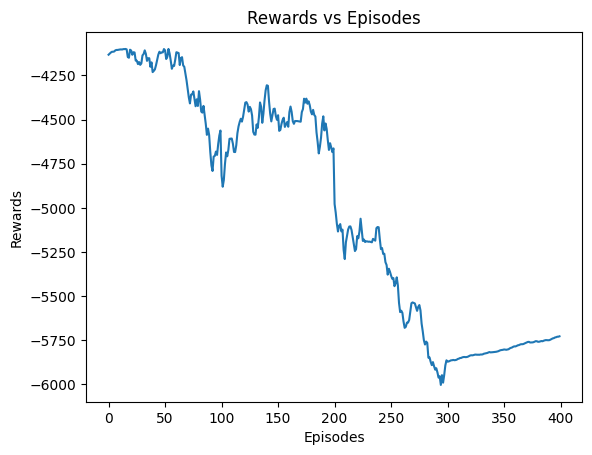

In [5]:
# Plot rewards
import matplotlib.pyplot as plt
episodes, rewards_list = zip(*rewards)
plt.plot(episodes, rewards_list)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards vs Episodes')
plt.show()